# Quaternion convolutional layers reproduction

Firstly I want to check if it possible to recreate the paper. This process will consist of the following steps

- Dataloader
- DataFormatter
- QCNN import 
- QNN import
- Recreate archtitecture 
- Train

# Questions for the following session

- Where does the conversion to quaternions happen
- When we input the output feautures map into the Qlinearlayer we lose all our information right
- Why do de images needed te be padded with a extra dimension

# To do following session

- Train the network

## Modules


In [1]:
import numpy as np
import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import core_qnn as qcnn

## Dataloader

In [2]:
# Tranform data to PyTorch tensore
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

# Download the data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# Define the loaders
train_loader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_testset, batch_size=1000)

# Here we can add some data cleanup

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


images.shape: torch.Size([64, 3, 32, 32])


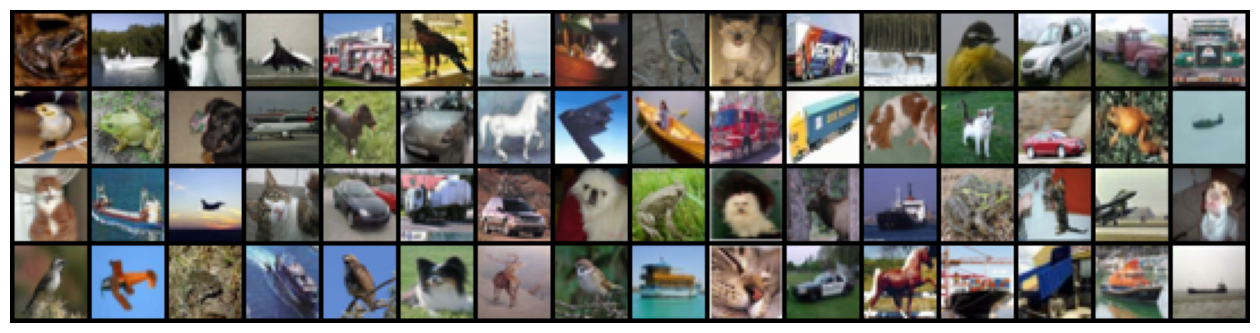

In [3]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

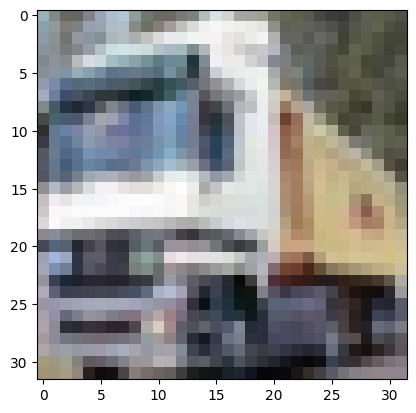

In [4]:
image, label  = cifar_trainset[1] 
plt.imshow(image.view(3,32,32).permute((1, 2, 0)))

## Creating the architecture

In [26]:
import torch
import torch.nn as nn
from   torch.nn import Parameter
from   torch.nn import functional as F
import torch.optim
from   torch.autograd import Variable
from   torch import autograd
import numpy as np

from   core_qnn.quaternion_layers import QuaternionLinear, QuaternionTransposeConv, QuaternionConv


class QAE(nn.Module):

    def __init__(self):
        super(QAE, self).__init__()
        
        self.e1 = QuaternionConv(4, 4, kernel_size=3, stride=2, padding=1)
        self.e2 = QuaternionConv(4, 4, kernel_size=3, stride=2, padding=1)
        self.e3 = QuaternionLinear(256, 10)
        self.act = nn.ReLU()
        self.output_act = nn.Sigmoid() 
        



    def forward(self, x):

        # Format to torch tensor
        x = torch.from_numpy(np.expand_dims(x, axis=0)).float()

        output1 = self.e1( x  )
        output2 = self.e2(output1)
        output3 = self.act(output2)
        output4 = self.e3(output3.view(1,256))
        out = self.output_act(output4)


        return out

    def name(self):
        return "QAE"

## Dataformatter

In [68]:
import os
from   imageio import imread,imwrite
import numpy   as np
import sys

SAMPLES = 1000

NUM_EPOCHS = 30001
LEARNING_RATE = 0.0005

data_placeholder = np.zeros((SAMPLES,4,32,32))
label_placeholder = np.zeros((SAMPLES,))

# Dataformatter
for i in range(SAMPLES):
    images, labels =  cifar_trainset[i]
    if labels > 7: 
        continue

    # This will functino as out "Picture"
    train = images.permute((1, 2, 0))

    # Copied from the online git
    # We are giving it an extra dimension not so sure why
    npad  = ((0, 0), (0, 0), (1, 0))
    train = np.pad(train, pad_width=npad, mode='constant', constant_values=0)
    train = np.transpose(train, (2,0,1))
    train = np.reshape(train, (1, train.shape[0], train.shape[1], train.shape[2]))
    data_placeholder[i] = train
    label_placeholder[i] = labels

data_placeholder.shape


(1000, 4, 32, 32)

In [69]:
label_placeholder.max()

7.0

# Let's try it with a single picture

In [46]:
import torch.nn.functional as F
# Manual

convulution = QuaternionConv(4, 4, kernel_size=3, stride=2, padding=1)
linear = QuaternionLinear(256 , 10)

def manual_forward(train):
    output1 = convulution.forward( train  )
    output2 = convulution.forward(output1)
    output3 = F.relu(output2)
    output4 = linear.forward(output3.view(1,256))
    result = F.sigmoid(output4)
    print(result.shape)
    return

manual_forward(torch.from_numpy(np.expand_dims(data_placeholder[2], axis=0)).float() )

torch.Size([1, 8])


## Let's see if the forward works of the function

In [32]:
jap = QAE()

jap.forward(data_placeholder[2])

tensor([[0.5576, 0.4793, 0.5163, 0.4417, 0.4542, 0.5230, 0.5268, 0.4885]],
       grad_fn=<SigmoidBackward0>)

## Training the network (still needs to be done)



In [86]:
# Initialize net 
net = QAE( )

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 800


for epoch in range(NUM_EPOCHS):

    output = net.forward(data_placeholder[epoch])

    index = output[0].argmax()
    
    answer_one_hot = th.Tensor([0,0,0,0,0,0,0,0])
    answer_one_hot[index] = 1
    criterion = nn.MSELoss()

    loss =  criterion(output[0] , answer_one_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("epoch "+str(epoch+1)+", loss_train "+str(loss.cpu().item()))



epoch 1, loss_train 0.22684837877750397
epoch 2, loss_train 0.24987730383872986
epoch 3, loss_train 0.2495904415845871
epoch 4, loss_train 0.21484999358654022
epoch 5, loss_train 0.2081013023853302
epoch 6, loss_train 0.21791231632232666
epoch 7, loss_train 0.21597406268119812
epoch 8, loss_train 0.20410187542438507
epoch 9, loss_train 0.248011514544487
epoch 10, loss_train 0.22965788841247559
epoch 11, loss_train 0.21747088432312012
epoch 12, loss_train 0.20932608842849731
epoch 13, loss_train 0.20597995817661285
epoch 14, loss_train 0.19594533741474152
epoch 15, loss_train 0.2457030713558197
epoch 16, loss_train 0.24520441889762878
epoch 17, loss_train 0.24467504024505615
epoch 18, loss_train 0.17262765765190125
epoch 19, loss_train 0.1882745772600174
epoch 20, loss_train 0.1853180229663849
epoch 21, loss_train 0.14457707107067108
epoch 22, loss_train 0.141755148768425
epoch 23, loss_train 0.17563079297542572
epoch 24, loss_train 0.16146209836006165
epoch 25, loss_train 0.16550238430

In [87]:
net.forward(data_placeholder[999])

tensor([[4.1805e-04, 3.0790e-04, 1.4959e-04, 1.4359e-04, 8.7032e-04, 9.9984e-01,
         6.3247e-04, 1.4009e-04]], grad_fn=<SigmoidBackward0>)

In [88]:
label_placeholder[999]

5.0